# Entrenamiento para Modelos RL

## Librerias

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from gym_envs import make_galaxian_env
from utils import set_global_seed, get_seed
from models import DQN, DuelingDQN
from replay_buffer import ReplayBuffer

import matplotlib.pyplot as plt

## Configuración de CUDA

In [2]:
seed = get_seed()
if seed is not None:
    print(f"Usando SEED global = {seed}")
    set_global_seed(seed)
else:
    # Crear una semilla aleatoria y usarla
    seed = np.random.randint(0, 10000)
    set_global_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Usando SEED global = 42
Using GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Creación de Entorno con procesamiento

In [3]:
# Crear entorno con preprocesamiento estilo DeepMind
env = make_galaxian_env(
    render_mode=None,           # para entrenamiento, más rápido
    deepmind_wrappers=True,     # aplica AtariPreprocessing + FrameStackObservation
    frame_stack=4,              # número de frames a apilar
)

# Probar entorno
obs, info = env.reset()
print("Tipo de obs:", type(obs))
obs_arr = np.array(obs, copy=False)
print("Shape de obs (np.array):", obs_arr.shape)
print("Dtype de obs:", obs_arr.dtype)

num_actions = env.action_space.n
print("Número de acciones:", num_actions)

Tipo de obs: <class 'numpy.ndarray'>
Shape de obs (np.array): (4, 84, 84)
Dtype de obs: uint8
Número de acciones: 6


## Helper para convertir obs → estado (C, H, W)

In [4]:
def obs_to_state(obs) -> np.ndarray:
    """
    Convierte la observación del entorno (que puede venir como LazyFrames
    u otro tipo) a un np.ndarray con shape (C, H, W).
    Args:
        obs: observación del entorno
    Returns:
        np.ndarray con shape (C, H, W)
    """
    arr = np.array(obs, copy=False)

    if arr.ndim == 3:
        # Casos típicos:
        # - (H, W, C)
        # - (C, H, W)
        H, W = 84, 84  # por diseño de AtariPreprocessing

        if arr.shape[0] == H and arr.shape[1] == W:
            # (H, W, C) -> (C, H, W)
            arr = np.transpose(arr, (2, 0, 1))
        elif arr.shape[1] == H and arr.shape[2] == W:
            # ya está en (C, H, W), no tocamos
            pass
        else:
            raise ValueError(f"Shape de obs inesperado: {arr.shape}")
    elif arr.ndim == 2:
        # 1 frame (H, W) -> (1, H, W)
        arr = arr[None, ...]
    else:
        raise ValueError(f"Obs con ndim no soportado: {arr.ndim}")

    return arr

## Función de entrenamiento

In [5]:
def train_dqn_variant(
    model_class,                 # DQN o DuelingDQN
    num_episodes: int,
    max_steps: int,
    label: str = "DQN",
    seed_base: int | None = None,
):
    """
    Entrena un modelo DQN-like (DQN o DuelingDQN) en Galaxian.
    Crea:
        - nuevo env
        - nuevo modelo online/target
        - nuevo replay buffer
        - su propio loop de entrenamiento

    Args:
        - model_class: clase del modelo a usar (DQN o DuelingDQN)
        - num_episodes: número de episodios para entrenar
        - max_steps: número máximo de pasos por episodio
        - label: etiqueta para identificar la variante en los logs
        - seed_base: semilla base para reproducibilidad (opcional)

    Returns:
        - lista de recompensas por episodio
        - lista de longitudes de episodio
    """

    # Reset inicial para definir input shape
    if seed_base is not None:
        obs, _ = env.reset(seed=seed_base)
    else:
        obs, _ = env.reset()

    state = obs_to_state(obs)
    in_channels = state.shape[0]
    num_actions = env.action_space.n

    # Redes online y target
    online_net = model_class(in_channels=in_channels, num_actions=num_actions).to(device)
    target_net = model_class(in_channels=in_channels, num_actions=num_actions).to(device)
    target_net.load_state_dict(online_net.state_dict())
    target_net.eval()

    # Optimizador
    optimizer = optim.Adam(online_net.parameters(), lr=1e-4)

    # Replay buffer
    buffer_capacity = 50_000
    obs_shape = state.shape
    replay_buffer = ReplayBuffer(
        capacity=buffer_capacity,
        obs_shape=obs_shape,
        device=device,
        dtype=np.uint8,
    )

    # Hiperparámetros
    gamma = 0.99
    batch_size = 32
    start_learning_after = 5_000
    target_update_freq = 5_000
    epsilon_start = 1.0
    epsilon_end = 0.1
    epsilon_decay_steps = 100_000

    def epsilon_by_step(step: int) -> float:
        """
        Calcula el valor de epsilon para el paso dado.
        Args:
            step: paso global actual
        Returns:
            valor de epsilon
        """
        if step >= epsilon_decay_steps:
            return epsilon_end
        else:
            return epsilon_start - (epsilon_start - epsilon_end) * (step / epsilon_decay_steps)

    def select_action(state: np.ndarray, step: int) -> int:
        """
        Selecciona una acción usando una política epsilon-greedy.
        Args:
            state: estado actual
            step: paso global actual
        Returns:
            acción seleccionada
        """
        eps = epsilon_by_step(step)
        if np.random.rand() < eps:
            return np.random.randint(0, num_actions)
        else:
            state_t = torch.as_tensor(state, device=device).unsqueeze(0)
            with torch.no_grad():
                q_values = online_net(state_t)
                action = int(q_values.argmax(dim=1).item())
            return action

    def dqn_update():
        """
        Realiza una actualización del modelo DQN usando un batch de la replay buffer.
        Returns:
            valor de la pérdida (loss) o None si no se puede actualizar
        """
        if len(replay_buffer) < batch_size:
            return None

        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        q_values = online_net(states)
        q_sa = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = target_net(next_states)
            max_next_q = next_q_values.max(dim=1).values
            target = rewards + gamma * (1.0 - dones) * max_next_q

        loss = nn.MSELoss()(q_sa, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()

    # Loop de entrenamiento
    global_step = 0
    rewards_per_episode = []
    episode_lengths = []

    print(f"\n[TRAIN] Iniciando entrenamiento para {label}")

    for episode in range(1, num_episodes + 1):
        # si queremos reproducibilidad entre variantes, podemos desplazar la seed
        if seed_base is not None:
            obs, _ = env.reset(seed=seed_base + episode)
        else:
            obs, _ = env.reset()

        state = obs_to_state(obs)
        done = False
        episode_reward = 0.0
        steps_in_episode = 0

        if global_step >= max_steps:
            print(f"[{label}] Alcanzado max_steps={max_steps}. Fin del entrenamiento.")
            break

        while not done and global_step < max_steps:
            action = select_action(state, global_step)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            next_state = obs_to_state(next_obs)

            replay_buffer.add(
                state=state,
                action=action,
                reward=reward,
                next_state=next_state,
                done=done,
            )

            state = next_state
            episode_reward += reward
            global_step += 1

            if global_step > start_learning_after:
                _ = dqn_update()

            if global_step % target_update_freq == 0:
                target_net.load_state_dict(online_net.state_dict())

            if global_step >= max_steps:
                done = True
                break

            steps_in_episode += 1

        rewards_per_episode.append(episode_reward)
        
        print(
            f"[{label}] Episodio {episode:3d} | Paso global {global_step:7d} | "
            f"Reward: {episode_reward:5.1f} | Eps: {epsilon_by_step(global_step):.3f}"
        )
        episode_lengths.append(steps_in_episode)

    env.close()
    return rewards_per_episode, episode_lengths


## Entrenamiento de Modelos

In [6]:
num_episodes = 10          # para pruebas
max_steps = 5_000         # steps totales por variante

### DQN

In [7]:
rewards_dqn, len_dqn = train_dqn_variant(
    model_class=DQN,
    num_episodes=num_episodes,
    max_steps=max_steps,
    label="DQN",
    seed_base=seed,
)


[TRAIN] Iniciando entrenamiento para DQN
[DQN] Episodio   1 | Paso global     273 | Reward: 280.0 | Eps: 0.998
[DQN] Episodio   2 | Paso global    1037 | Reward: 1050.0 | Eps: 0.991
[DQN] Episodio   3 | Paso global    1433 | Reward: 450.0 | Eps: 0.987
[DQN] Episodio   4 | Paso global    2467 | Reward: 1260.0 | Eps: 0.978
[DQN] Episodio   5 | Paso global    2876 | Reward: 530.0 | Eps: 0.974
[DQN] Episodio   6 | Paso global    3834 | Reward: 1090.0 | Eps: 0.965
[DQN] Episodio   7 | Paso global    5000 | Reward: 1150.0 | Eps: 0.955
[DQN] Alcanzado max_steps=5000. Fin del entrenamiento.


### Dueling DQN

In [8]:
rewards_dueling, len_dueling = train_dqn_variant(
    model_class=DuelingDQN,
    num_episodes=num_episodes,
    max_steps=max_steps,
    label="DuelingDQN",
    seed_base=seed,
)


[TRAIN] Iniciando entrenamiento para DuelingDQN
[DuelingDQN] Episodio   1 | Paso global     263 | Reward: 390.0 | Eps: 0.998
[DuelingDQN] Episodio   2 | Paso global     599 | Reward: 380.0 | Eps: 0.995
[DuelingDQN] Episodio   3 | Paso global     941 | Reward: 300.0 | Eps: 0.992
[DuelingDQN] Episodio   4 | Paso global    1337 | Reward: 480.0 | Eps: 0.988
[DuelingDQN] Episodio   5 | Paso global    2150 | Reward: 1060.0 | Eps: 0.981
[DuelingDQN] Episodio   6 | Paso global    2582 | Reward: 660.0 | Eps: 0.977
[DuelingDQN] Episodio   7 | Paso global    3368 | Reward: 880.0 | Eps: 0.970
[DuelingDQN] Episodio   8 | Paso global    4267 | Reward: 880.0 | Eps: 0.962
[DuelingDQN] Episodio   9 | Paso global    4902 | Reward: 720.0 | Eps: 0.956
[DuelingDQN] Episodio  10 | Paso global    5000 | Reward:  90.0 | Eps: 0.955


## Gráficos

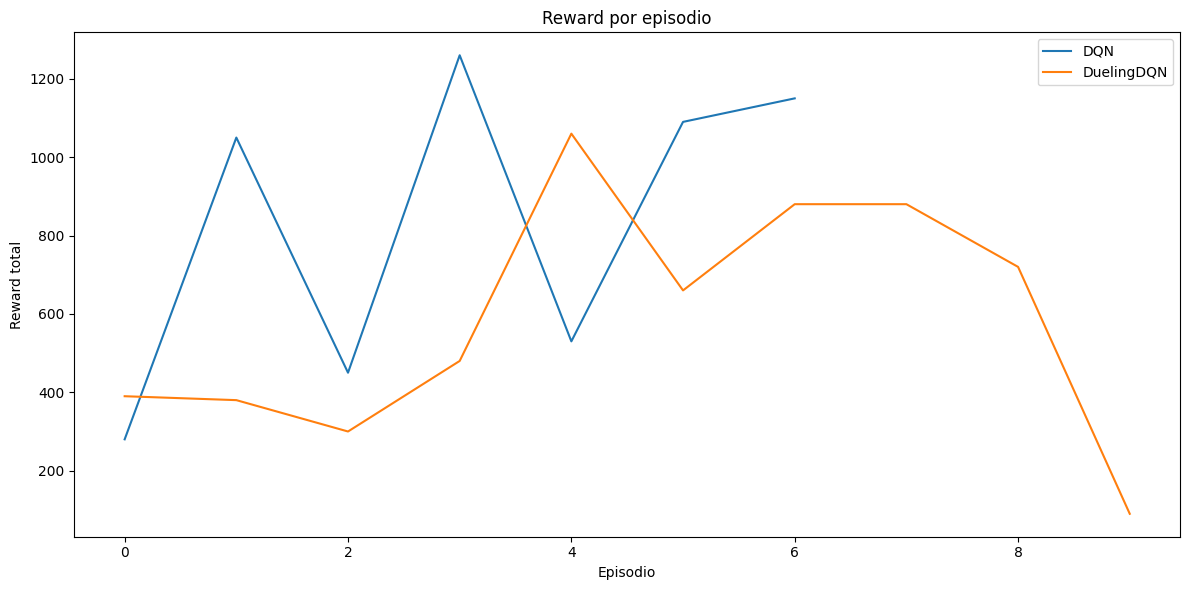

In [9]:
plt.figure(figsize=(12, 6))

# Plot bruto
plt.plot(rewards_dqn, label="DQN")
plt.plot(rewards_dueling, label="DuelingDQN")
plt.xlabel("Episodio")
plt.ylabel("Reward total")
plt.title("Reward por episodio")
plt.legend()

plt.tight_layout()
plt.show()

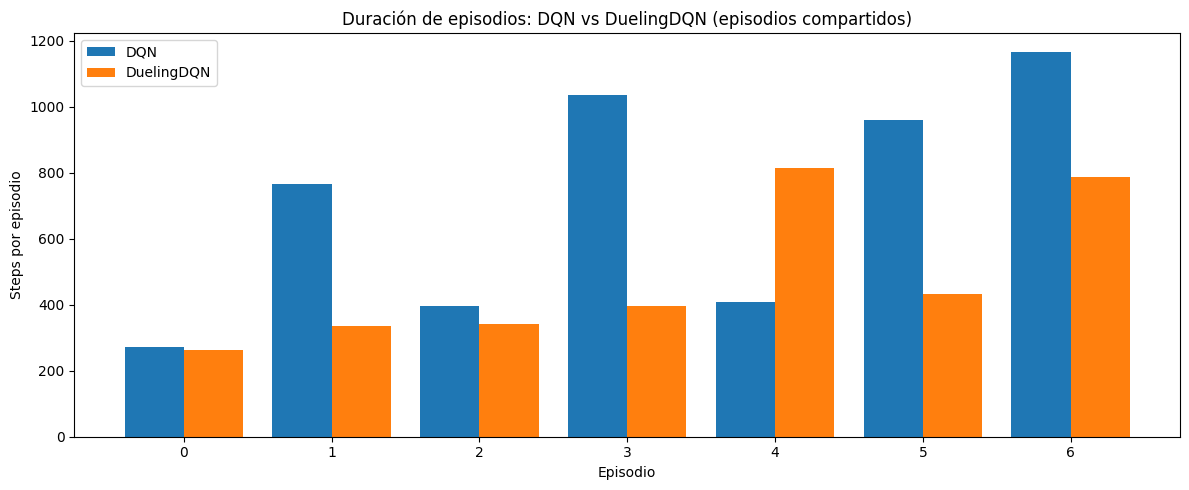

In [10]:
len_dqn = np.array(len_dqn)
len_dueling = np.array(len_dueling)

min_len = min(len(len_dqn), len(len_dueling))

episodes = np.arange(min_len)
bar_width = 0.4

plt.figure(figsize=(12, 5))

plt.bar(episodes - bar_width/2, len_dqn[:min_len], width=bar_width, label="DQN")
plt.bar(episodes + bar_width/2, len_dueling[:min_len], width=bar_width, label="DuelingDQN")

plt.xlabel("Episodio")
plt.ylabel("Steps por episodio")
plt.title("Duración de episodios: DQN vs DuelingDQN (episodios compartidos)")
plt.legend()
plt.tight_layout()
plt.show()